# Model Exploration
* This notebook is broken into two sections; Pre-Campaign Modeling, Post-Campaign modeling.
* The first section trains models using pre-campaign features of the dataset and then uses the whole dataset to try and predict which customers are likely to subscribe to a term deposit product 
* The second section looks at the dataset as a whole and attempts to minimize the call time that employees have to spend calling customers that are in actuality NOT going to subscribe to the product. Feature extraction is also implemented to see if model performance increases.

In [1502]:
import pandas as pd
import pycaret
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer, make_column_transformer
import warnings
warnings.filterwarnings(action='ignore')

In [1503]:
df_ = pd.read_parquet('Data/model-ready-term-deposit-marketing-2020.parquet')
df_.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,y,duration_in_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,0,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,0,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,0,1.266667
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,0,1.533333
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,0,3.300000


In [1658]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  40000 non-null  int64   
 1   job                  40000 non-null  category
 2   marital              40000 non-null  category
 3   education            40000 non-null  category
 4   default              40000 non-null  int32   
 5   balance              40000 non-null  int64   
 6   housing              40000 non-null  int32   
 7   loan                 40000 non-null  int32   
 8   contact              40000 non-null  category
 9   day                  40000 non-null  int64   
 10  month                40000 non-null  category
 11  campaign             40000 non-null  int64   
 12  y                    40000 non-null  int32   
 13  duration_in_minutes  40000 non-null  float64 
dtypes: category(5), float64(1), int32(4), int64(4)
memory usage: 2.3 MB


In [1659]:
target_variable = df_['y']

X = df_.drop(columns='y', axis=1)

X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,duration_in_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,1.266667
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,1.533333
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,3.300000


## Pre-Campaign Modeling
* Looking at the first 8 columns of features this section looks at obtaining the highest recall score for class 1
* Pycaret will be used to look for optimal models to look at more closely
* RandomizedSearch and Optuna will be used for hyperparameter tuning

In [1660]:
pre_campaign_df = X.iloc[:, 0:8]
pre_campaign_df.head()

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,0,2143,1,0
1,44,technician,single,secondary,0,29,1,0
2,33,entrepreneur,married,secondary,0,2,1,1
3,47,blue-collar,married,unknown,0,1506,1,0
4,33,unknown,single,unknown,0,1,0,0


In [1661]:
num_features = [col for col in pre_campaign_df.columns if X[col].dtype != 'category']
print(f"Numerical features:   {num_features}")
categ_features = [col for col in pre_campaign_df.columns if X[col].dtype == 'category']
print(f"Categorical features: {categ_features}")

Numerical features:   ['age', 'default', 'balance', 'housing', 'loan']
Categorical features: ['job', 'marital', 'education']


In [1508]:
from pycaret.classification import *
import random

seed = random.randint(1000, 9999)

imbalance_methods = ['randomoversampler', 'smotetomek', 'smoteenn']
n_select = 5
imbalance_type_dict = {}


for type in imbalance_methods:
  print(f'Type of imbalance technique: {type}')
  s = setup(data=pre_campaign_df,
        target=target_variable, 
        session_id=seed, 
        train_size=.80, 
        fix_imbalance=True, 
        fix_imbalance_method=type,
        categorical_features=categ_features
      )
  # print(s.X_train)
  print()
  best_models = compare_models(sort='Recall', n_select=n_select)
  results = pull()
  # print(best_models)

  model_recall_score_dict = {}

  for i in range(n_select):
      model_recall_score_dict[results.index[i]] = results.iloc[i].Recall

  imbalance_type_dict[type] = model_recall_score_dict

  print(imbalance_type_dict)

  evaluation = [evaluate_model(estimator=model) for model in best_models]
  print('-'*50)


Type of imbalance technique: randomoversampler


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 9)"
4,Transformed data shape,"(67366, 25)"
5,Transformed train set shape,"(59366, 25)"
6,Transformed test set shape,"(8000, 25)"
7,Numeric features,5
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.4641,0.5341,0.6028,0.0754,0.1245,0.0085,0.0320,0.5990
lr,Logistic Regression,0.5923,0.6033,0.5615,0.0976,0.1663,0.0489,0.0821,2.1790
ridge,Ridge Classifier,0.5930,0.6031,0.5615,0.0977,0.1665,0.0492,0.0825,0.1190
lda,Linear Discriminant Analysis,0.5930,0.6031,0.5615,0.0977,0.1665,0.0492,0.0825,0.2810
nb,Naive Bayes,0.5807,0.5924,0.5528,0.0937,0.1603,0.0416,0.0711,0.0880
ada,Ada Boost Classifier,0.6196,0.6140,0.5261,0.0992,0.1669,0.0513,0.0816,1.2380
gbc,Gradient Boosting Classifier,0.6504,0.6144,0.4894,0.1019,0.1687,0.0554,0.0830,3.3040
qda,Quadratic Discriminant Analysis,0.5704,0.5211,0.4564,0.0787,0.1274,0.0113,0.0197,0.2480
lightgbm,Light Gradient Boosting Machine,0.6989,0.6091,0.4346,0.1078,0.1726,0.0641,0.0878,1.0850
xgboost,Extreme Gradient Boosting,0.7412,0.5834,0.3599,0.1092,0.1676,0.0636,0.0796,0.8140


{'randomoversampler': {'svm': 0.6028, 'lr': 0.5615, 'ridge': 0.5615, 'lda': 0.5615, 'nb': 0.5528}}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

--------------------------------------------------
Type of imbalance technique: smotetomek


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 9)"
4,Transformed data shape,"(65490, 25)"
5,Transformed train set shape,"(57490, 25)"
6,Transformed test set shape,"(8000, 25)"
7,Numeric features,5
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.4720,0.5745,0.6348,0.0839,0.1482,0.0233,0.0491,7.1640
lr,Logistic Regression,0.5939,0.6030,0.5649,0.0984,0.1676,0.0505,0.0847,8.3370
ridge,Ridge Classifier,0.5930,0.6027,0.5623,0.0979,0.1667,0.0495,0.0829,5.9960
lda,Linear Discriminant Analysis,0.5930,0.6027,0.5623,0.0979,0.1667,0.0495,0.0829,7.1010
svm,SVM - Linear Kernel,0.5335,0.5080,0.4927,0.0727,0.1116,0.0027,0.0190,8.3770
knn,K Neighbors Classifier,0.6470,0.5340,0.3815,0.0823,0.1354,0.0185,0.0271,7.9450
dt,Decision Tree Classifier,0.8677,0.5372,0.1493,0.1325,0.1404,0.0690,0.0692,7.4390
et,Extra Trees Classifier,0.8927,0.5684,0.1010,0.1483,0.1200,0.0651,0.0665,8.7770
rf,Random Forest Classifier,0.9091,0.5786,0.0764,0.1866,0.1083,0.0693,0.0770,10.1900
qda,Quadratic Discriminant Analysis,0.9105,0.4933,0.0224,0.0511,0.0249,0.0003,-0.0030,7.7010


{'randomoversampler': {'svm': 0.6028, 'lr': 0.5615, 'ridge': 0.5615, 'lda': 0.5615, 'nb': 0.5528}, 'smotetomek': {'nb': 0.6348, 'lr': 0.5649, 'ridge': 0.5623, 'lda': 0.5623, 'svm': 0.4927}}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

--------------------------------------------------
Type of imbalance technique: smoteenn


,Description,Value
0,Session id,3046
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 9)"
4,Transformed data shape,"(46900, 25)"
5,Transformed train set shape,"(38900, 25)"
6,Transformed test set shape,"(8000, 25)"
7,Numeric features,5
8,Categorical features,3
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.0724,0.5000,1.0000,0.0724,0.1350,0.0000,0.0000,4.9620
ridge,Ridge Classifier,0.2963,0.5989,0.8334,0.0802,0.1464,0.0165,0.0527,6.2330
lda,Linear Discriminant Analysis,0.3047,0.5989,0.8286,0.0808,0.1472,0.0175,0.0549,4.8410
lr,Logistic Regression,0.3051,0.5994,0.8278,0.0807,0.1471,0.0175,0.0547,8.6590
nb,Naive Bayes,0.4344,0.5700,0.6793,0.0831,0.1481,0.0219,0.0499,5.6970
svm,SVM - Linear Kernel,0.5178,0.5069,0.5021,0.0697,0.1119,-0.0022,0.0135,7.8790
knn,K Neighbors Classifier,0.5454,0.5280,0.4937,0.0788,0.1360,0.0127,0.0225,6.1680
dt,Decision Tree Classifier,0.8096,0.5452,0.2361,0.1124,0.1522,0.0600,0.0653,7.6250
et,Extra Trees Classifier,0.8618,0.5800,0.1562,0.1287,0.1411,0.0668,0.0671,5.4240
rf,Random Forest Classifier,0.8822,0.5913,0.1264,0.1442,0.1347,0.0718,0.0720,6.1090


{'randomoversampler': {'svm': 0.6028, 'lr': 0.5615, 'ridge': 0.5615, 'lda': 0.5615, 'nb': 0.5528}, 'smotetomek': {'nb': 0.6348, 'lr': 0.5649, 'ridge': 0.5623, 'lda': 0.5623, 'svm': 0.4927}, 'smoteenn': {'dummy': 1.0, 'ridge': 0.8334, 'lda': 0.8286, 'lr': 0.8278, 'nb': 0.6793}}


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

--------------------------------------------------


In [1509]:
new_X = get_config('X') #### the new X to use when exploring models below
new_X.head()

,age,job,marital,education,default,balance,housing,loan
20685,44,management,married,secondary,0,781,1,0
39744,51,management,married,tertiary,0,994,0,0
25714,54,services,married,unknown,0,386,0,1
15848,26,admin,married,secondary,0,233,1,0
23373,54,management,divorced,tertiary,0,124,0,0


In [1510]:
new_y = get_config('y') #### the new y to use when exploring models below
new_y

20685    0
39744    0
25714    0
15848    0
23373    0
        ..
39534    0
8858     0
28540    0
18981    0
23493    0
Name: y, Length: 40000, dtype: int8

                      svm      lr   ridge     lda      nb
randomoversampler  0.6028  0.5615  0.5615  0.5615  0.5528
smotetomek         0.4927  0.5649  0.5623  0.5623  0.6348
smoteenn              NaN  0.8278  0.8334  0.8286  0.6793


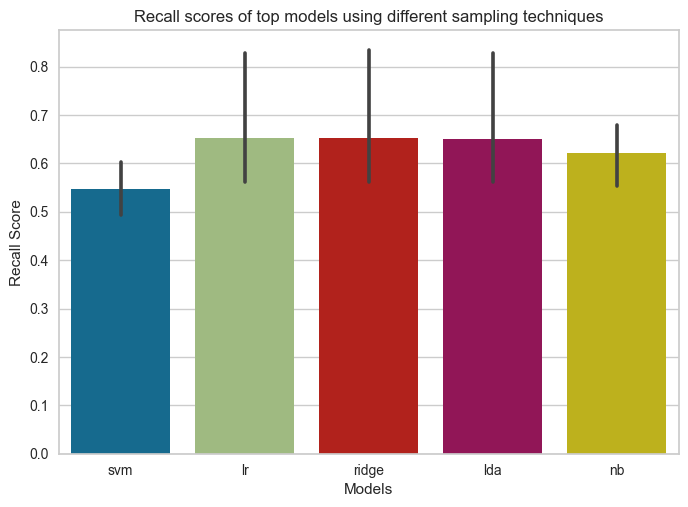

In [1511]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data=imbalance_type_dict)
df = df.T.drop(columns='dummy', axis=1)
print(df)

sns.barplot(data=df)
plt.xlabel('Models')
plt.ylabel('Recall Score')
plt.title('Recall scores of top models using different sampling techniques')
plt.show()

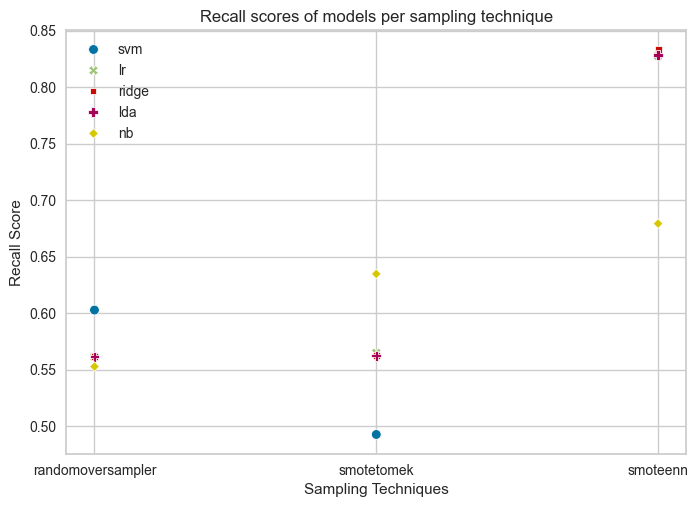

In [1512]:
sns.scatterplot(df)
plt.xlabel('Sampling Techniques')
plt.ylabel('Recall Score')
plt.title('Recall scores of models per sampling technique')
plt.show()

Based on multiple tests to see what models and sampling techniques worked best, the results show a smoteenn technique working better for recall scores and the models that performed the best with smoteenn will be used along with svm.

## Model Experimentation
* This section will look at different models to explore as well as look at replicating some of the scores from above with the different sampling techniques

In [1620]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.combine import SMOTETomek, SMOTEENN

ros = RandomOverSampler(random_state=seed)
smotenc = SMOTENC(categorical_features=categ_features, sampling_strategy='all', random_state=seed)
smoteenn = SMOTEENN(random_state=seed)

dummy_df = pd.get_dummies(new_X)

X_train, X_test, y_train, y_test = train_test_split(dummy_df,
                                                    new_y, 
                                                    train_size=.80, 
                                                    random_state=seed
                                                    )

X_train_resample, y_train_resample = smoteenn.fit_resample(X_train, y_train)

In [1621]:
original_target_distribution = new_y.sum()/new_X.shape[0]
original_target_distribution

0.0724

In [1622]:
y_train_resample.sum()/X_train_resample.shape[0]

0.6166415153249727

In [1623]:
lr = LogisticRegression(random_state=seed)
lda = LinearDiscriminantAnalysis()
ridge = RidgeClassifier(random_state=seed)
gaussian_nb = GaussianNB()
sdg = SGDClassifier(random_state=seed)

models_dict = {
    'Logistic Regression': lr,
    'Linear Discrimination Analysis': lda,
    'Ridge Classifier': ridge,
    'Gaussian Naive-Bayes': gaussian_nb,
    'Stochastic Gradient Descent': sdg
    }


In [1624]:

# import numpy as np
# dummy_df = pd.get_dummies(new_X)

# X_train, X_test, y_train, y_test = train_test_split(dummy_df,
#                                                     new_y, 
#                                                     train_size=.80, 
#                                                     random_state=seed, 
#                                                     # stratify=y_resampled
#                                                     )

# X_resampled, y_resampled = SMOTENC(categorical_features=np.arange(5,23), random_state=seed).fit_resample(X=X_train, y=y_train)

# # X_resampled

# for name, model in models_dict.items():
#     print(f"{'*'*40} Model: {name} {'*'*40}")
#     model.fit(X_resampled, y_resampled)
#     y_preds = model.predict(X_test)
#     print(classification_report(y_test, y_preds))

In [1625]:
sampling_techniques = [ros, SMOTETomek(random_state=seed), smoteenn]

for tech in sampling_techniques:
    dummy_df = pd.get_dummies(new_X)

    X_train, X_test, y_train, y_test = train_test_split(dummy_df, new_y, train_size=.80, random_state=seed)

    X_train_resample, y_train_resample = tech.fit_resample(X_train, y_train)

    print(f"Sampling technique: {tech}")
    for name, model in models_dict.items():
        print(f"{'*'*40} Model: {name} {'*'*40}")
        model.fit(X_train_resample, y_train_resample)
        y_preds = model.predict(X_test)
        print(classification_report(y_test, y_preds))
        print(confusion_matrix(y_test, y_preds))

Sampling technique: RandomOverSampler(random_state=5137, sampling_strategy='auto', shrinkage=None)
**************************************** Model: Logistic Regression ****************************************
              precision    recall  f1-score   support

           0       0.95      0.57      0.71      7421
           1       0.09      0.58      0.16       579

    accuracy                           0.57      8000
   macro avg       0.52      0.57      0.44      8000
weighted avg       0.88      0.57      0.67      8000

[[4240 3181]
 [ 246  333]]
**************************************** Model: Linear Discrimination Analysis ****************************************
              precision    recall  f1-score   support

           0       0.94      0.58      0.72      7421
           1       0.10      0.56      0.16       579

    accuracy                           0.58      8000
   macro avg       0.52      0.57      0.44      8000
weighted avg       0.88      0.58      0.68   

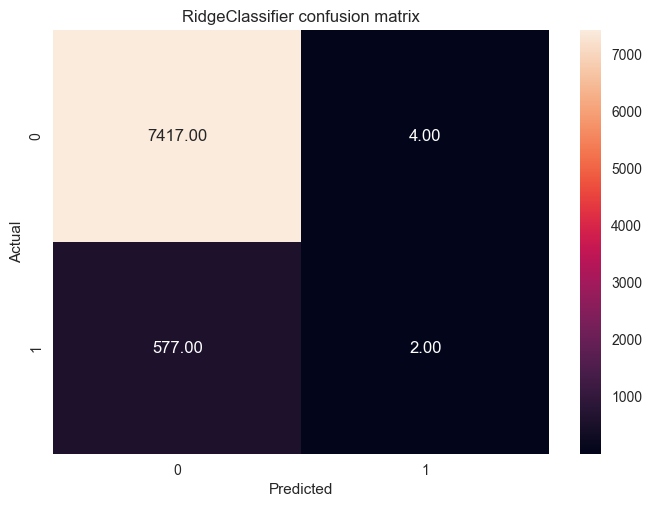

In [1626]:
models_dict['Ridge Classifier'].fit(X_train_resample, y_train_resample)
pred = models_dict['Ridge Classifier'].predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt='.2f')
plt.title('RidgeClassifier confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

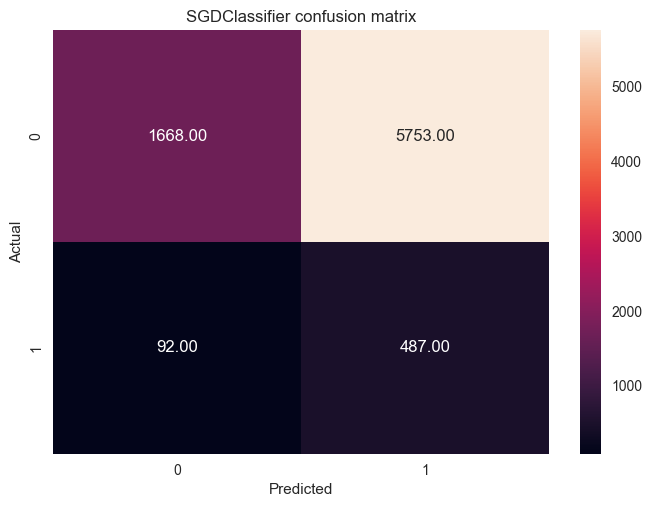

In [1627]:
models_dict['Stochastic Gradient Descent'].fit(X_train_resample, y_train_resample)
pred = models_dict['Stochastic Gradient Descent'].predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt='.2f')
plt.title('SGDClassifier confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The two confusion matrices show the difference between the true positives and the false negatives. Thus the wildly different recall scores.

### Hyperparameter Tuning
* SGDClassifier model will be tuned due to the fact that the amount of false negatives where considerably lower than the other models

In [1628]:
import numpy as np
import optuna

n = X_train_resample.shape[0]
svm = models_dict['Stochastic Gradient Descent']

params = {
    'alpha': np.arange(.0000001, 1, 10),
    # 'max_iter': np.arange(1, 1000, 100)
    'max_iter': np.arange(200, 1000, 50)
}

random_grid_search = RandomizedSearchCV(estimator=svm, param_distributions=params, random_state=seed, cv=5, scoring='recall')

random_grid_search.fit(X_train_resample, y_train_resample)

preds = random_grid_search.predict(X_test)
print(f"Best params: {random_grid_search.best_params_}")

Best params: {'max_iter': 850, 'alpha': 1e-07}


In [1629]:
tuned_sgd = SGDClassifier(alpha=1e-07, max_iter=900)
tuned_sgd.fit(X_train_resample, y_train_resample)

preds = tuned_sgd.predict(X_test)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.20      0.33      7421
           1       0.08      0.85      0.14       579

    accuracy                           0.25      8000
   macro avg       0.51      0.52      0.23      8000
weighted avg       0.88      0.25      0.32      8000

[[1481 5940]
 [  89  490]]


In [1630]:
def objective(trial):
    svm_alpha = trial.suggest_float('svm_alpha', 1e-07, 1, log=True)
    svm_max_iter = trial.suggest_int('svm_max_iter', 200, 1000)
    regressor_obj = SGDClassifier(alpha=svm_alpha, max_iter=svm_max_iter)
    
    dummy_df = pd.get_dummies(new_X)
    
    X_train, X_test, y_train, y_test = train_test_split(dummy_df, new_y, train_size=.80, random_state=seed)

    X_train_resample, y_train_resample = smoteenn.fit_resample(X_train, y_train)

    regressor_obj.fit(X_train_resample, y_train_resample)
    preds = regressor_obj.predict(X_test)
    print(classification_report(y_test, preds))

study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2024-09-26 09:37:03,003] A new study created in memory with name: no-name-64d9861f-6d07-4bb8-a120-602a760168e5
[W 2024-09-26 09:38:42,747] Trial 0 failed with parameters: {'svm_alpha': 0.0001888511011281689, 'svm_max_iter': 286} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:38:42,750] Trial 0 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.28      0.44      7421
           1       0.08      0.80      0.15       579

    accuracy                           0.32      8000
   macro avg       0.51      0.54      0.29      8000
weighted avg       0.88      0.32      0.42      8000



[W 2024-09-26 09:40:06,197] Trial 1 failed with parameters: {'svm_alpha': 4.15968287528716e-06, 'svm_max_iter': 400} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:40:06,201] Trial 1 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.25      0.39      7421
           1       0.08      0.82      0.14       579

    accuracy                           0.29      8000
   macro avg       0.51      0.53      0.27      8000
weighted avg       0.88      0.29      0.38      8000



[W 2024-09-26 09:41:22,301] Trial 2 failed with parameters: {'svm_alpha': 7.594400634506169e-05, 'svm_max_iter': 869} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:41:22,303] Trial 2 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.34      0.50      7421
           1       0.08      0.75      0.15       579

    accuracy                           0.37      8000
   macro avg       0.51      0.55      0.32      8000
weighted avg       0.88      0.37      0.48      8000



[W 2024-09-26 09:42:39,324] Trial 3 failed with parameters: {'svm_alpha': 0.00022854533381618002, 'svm_max_iter': 432} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:42:39,325] Trial 3 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.88      0.90      7421
           1       0.06      0.09      0.07       579

    accuracy                           0.82      8000
   macro avg       0.49      0.49      0.49      8000
weighted avg       0.86      0.82      0.84      8000



[W 2024-09-26 09:43:56,034] Trial 4 failed with parameters: {'svm_alpha': 0.004591268532654977, 'svm_max_iter': 540} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:43:56,036] Trial 4 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.14      0.24      7421
           1       0.08      0.90      0.14       579

    accuracy                           0.19      8000
   macro avg       0.51      0.52      0.19      8000
weighted avg       0.88      0.19      0.23      8000



[W 2024-09-26 09:45:36,068] Trial 5 failed with parameters: {'svm_alpha': 1.9470039992220274e-07, 'svm_max_iter': 996} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:45:36,071] Trial 5 failed with value None.


              precision    recall  f1-score   support

           0       0.94      0.21      0.34      7421
           1       0.08      0.84      0.14       579

    accuracy                           0.26      8000
   macro avg       0.51      0.53      0.24      8000
weighted avg       0.88      0.26      0.33      8000



[W 2024-09-26 09:47:06,103] Trial 6 failed with parameters: {'svm_alpha': 0.02262343675235611, 'svm_max_iter': 609} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:47:06,109] Trial 6 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.90      0.91      7421
           1       0.08      0.12      0.10       579

    accuracy                           0.84      8000
   macro avg       0.51      0.51      0.51      8000
weighted avg       0.87      0.84      0.85      8000



[W 2024-09-26 09:48:33,450] Trial 7 failed with parameters: {'svm_alpha': 0.0014492163326721703, 'svm_max_iter': 791} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:48:33,452] Trial 7 failed with value None.


              precision    recall  f1-score   support

           0       0.95      0.26      0.41      7421
           1       0.08      0.81      0.14       579

    accuracy                           0.30      8000
   macro avg       0.51      0.54      0.28      8000
weighted avg       0.88      0.30      0.39      8000



[W 2024-09-26 09:49:50,601] Trial 8 failed with parameters: {'svm_alpha': 0.0001834080947901134, 'svm_max_iter': 423} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:49:50,603] Trial 8 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.86      0.89      7421
           1       0.06      0.12      0.08       579

    accuracy                           0.81      8000
   macro avg       0.49      0.49      0.49      8000
weighted avg       0.86      0.81      0.83      8000



[W 2024-09-26 09:51:10,285] Trial 9 failed with parameters: {'svm_alpha': 7.346627088353188e-05, 'svm_max_iter': 935} because of the following error: The value None could not be cast to float..
[W 2024-09-26 09:51:10,287] Trial 9 failed with value None.


              precision    recall  f1-score   support

           0       0.93      0.79      0.85      7421
           1       0.07      0.22      0.11       579

    accuracy                           0.75      8000
   macro avg       0.50      0.50      0.48      8000
weighted avg       0.87      0.75      0.80      8000



In [1631]:
sdg = SGDClassifier(alpha=0.004591268532654977, max_iter=540, random_state=seed)

sdg.fit(X_train_resample, y_train_resample)
preds = sdg.predict(X_test)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.29      0.44      7421
           1       0.08      0.80      0.15       579

    accuracy                           0.32      8000
   macro avg       0.51      0.54      0.29      8000
weighted avg       0.88      0.32      0.42      8000

[[2136 5285]
 [ 118  461]]


              precision    recall  f1-score   support

           0       0.98      0.64      0.77      7379
           1       0.17      0.88      0.28       621

    accuracy                           0.66      8000
   macro avg       0.58      0.76      0.53      8000
weighted avg       0.92      0.66      0.74      8000



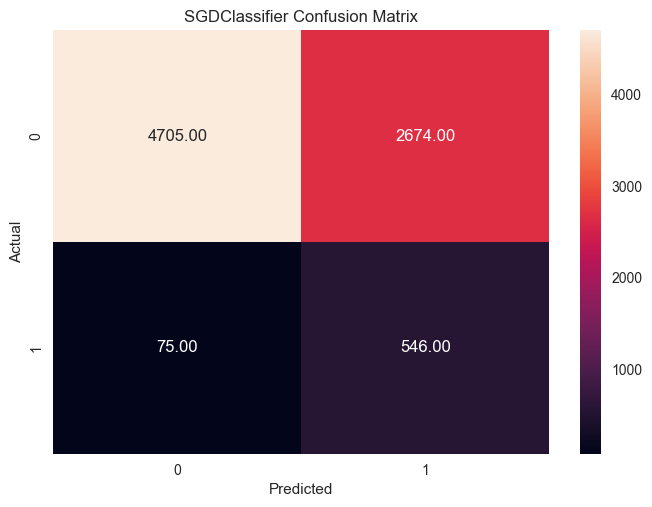

In [1638]:
## using the trained, RandomizedSearch SGD model from above this now trains on the whole dataset to see how well it predicts customers who will subscribe

X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X), target_variable, train_size=.80, random_state=seed)
X_train_resample, y_train_resample = smoteenn.fit_resample(X_train, y_train)

tuned_sgd.fit(X_train_resample, y_train_resample)
preds = tuned_sgd.predict(X_test)
print(classification_report(y_test, preds))
sns.heatmap(data=confusion_matrix(y_test, preds), fmt='.2f', annot=True)
plt.title('SGDClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Using the trained SGD model on the whole dataset using SMOTEenn for the sampling technique we can see that a recall score of ~91% is achieved. Meaning that this model is classifying over 90% of the customers in the dataset as customers who will subscribe to the term deposit product.

## Post-Campaign Modeling
* The second section of this notebook looks to take the whole dataset and see how much call time can be reduced as well as looking at relevant features to see how that impacts the models performance.
* Using Pycaret, we will see which models perform well with the entire dataset looking at the precision metric. The precision score will be best for seeing how well the model is at classifying customers who WILL subscribe to the term deposit product.

In [1662]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,duration_in_minutes
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,4.350000
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,2.516667
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,1.266667
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,1.533333
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,3.300000


In [1667]:
full_dataset_categorical_features = [col for col in X.columns if X[col].dtype == 'category']
full_dataset_categorical_features

['job', 'marital', 'education', 'contact', 'month']

In [1677]:
seed = random.randint(1000, 9999)

imbalance_type_dict_layer_2 = {}

for type in imbalance_methods:
  print(f'Type of imbalance technique: {type}')
  s = setup(data=X,
        target=target_variable, 
        session_id=seed, 
        train_size=.80, 
        fix_imbalance=True, 
        fix_imbalance_method=type,
        categorical_features=full_dataset_categorical_features
      )
  # print(s.X_train)
  print()
  best_models = compare_models(sort='Precision', n_select=n_select)
  results = pull()
  # print(best_models)

  model_precision_score_dict = {}

  for i in range(n_select):
      model_precision_score_dict[results.index[i]] = results.iloc[i]['Prec.']

  imbalance_type_dict_layer_2[type] = model_precision_score_dict

  print(imbalance_type_dict_layer_2)

  # evaluation = [evaluate_model(estimator=model) for model in best_models]
  print('-'*50)

Type of imbalance technique: randomoversampler


,Description,Value
0,Session id,3121
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(67366, 42)"
5,Transformed train set shape,"(59366, 42)"
6,Transformed test set shape,"(8000, 42)"
7,Numeric features,8
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9317,0.9220,0.2214,0.5765,0.3188,0.2903,0.3281,1.7800
rf,Random Forest Classifier,0.9343,0.9432,0.4199,0.5619,0.4802,0.4460,0.4516,1.7190
dt,Decision Tree Classifier,0.9190,0.6919,0.4264,0.4397,0.4325,0.3889,0.3892,0.2760
xgboost,Extreme Gradient Boosting,0.9085,0.9419,0.7708,0.4274,0.5496,0.5033,0.5307,0.4230
lightgbm,Light Gradient Boosting Machine,0.8903,0.9499,0.8874,0.3880,0.5398,0.4882,0.5424,0.6910
ridge,Ridge Classifier,0.8777,0.9262,0.8278,0.3534,0.4952,0.4382,0.4899,0.1690
lda,Linear Discriminant Analysis,0.8777,0.9262,0.8274,0.3533,0.4950,0.4380,0.4897,0.2580
gbc,Gradient Boosting Classifier,0.8724,0.9438,0.8917,0.3509,0.5034,0.4458,0.5101,2.8040
ada,Ada Boost Classifier,0.8685,0.9295,0.8507,0.3385,0.4841,0.4245,0.4841,0.9080
lr,Logistic Regression,0.8657,0.9297,0.8623,0.3347,0.4821,0.4217,0.4845,2.4710


{'randomoversampler': {'svm': 0.6028, 'lr': 0.5615, 'ridge': 0.5615, 'lda': 0.5615, 'nb': 0.5528}, 'smotetomek': {'nb': 0.6348, 'lr': 0.5649, 'ridge': 0.5623, 'lda': 0.5623, 'svm': 0.4927}, 'smoteenn': {'dummy': 1.0, 'ridge': 0.8334, 'lda': 0.8286, 'lr': 0.8278, 'nb': 0.6793}}
--------------------------------------------------
Type of imbalance technique: smotetomek


,Description,Value
0,Session id,3121
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(66800, 42)"
5,Transformed train set shape,"(58800, 42)"
6,Transformed test set shape,"(8000, 42)"
7,Numeric features,8
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9388,0.9513,0.4774,0.5977,0.5303,0.4980,0.5019,7.4030
xgboost,Extreme Gradient Boosting,0.9367,0.9471,0.4670,0.5788,0.5164,0.4830,0.4865,7.3080
rf,Random Forest Classifier,0.9330,0.9409,0.3250,0.5656,0.4123,0.3796,0.3963,8.8760
et,Extra Trees Classifier,0.9318,0.9301,0.3129,0.5529,0.3989,0.3658,0.3829,8.5090
gbc,Gradient Boosting Classifier,0.9323,0.9415,0.5106,0.5351,0.5219,0.4855,0.4860,13.2250
ada,Ada Boost Classifier,0.9215,0.9207,0.4441,0.4580,0.4500,0.4078,0.4084,9.0920
dt,Decision Tree Classifier,0.9159,0.7098,0.4687,0.4265,0.4463,0.4010,0.4017,7.0290
ridge,Ridge Classifier,0.8806,0.9287,0.8269,0.3594,0.5009,0.4449,0.4950,6.7890
lda,Linear Discriminant Analysis,0.8805,0.9287,0.8269,0.3593,0.5008,0.4447,0.4949,8.8200
lr,Logistic Regression,0.8715,0.9297,0.8468,0.3436,0.4887,0.4300,0.4876,9.3950


{'randomoversampler': {'svm': 0.6028, 'lr': 0.5615, 'ridge': 0.5615, 'lda': 0.5615, 'nb': 0.5528}, 'smotetomek': {'nb': 0.6348, 'lr': 0.5649, 'ridge': 0.5623, 'lda': 0.5623, 'svm': 0.4927}, 'smoteenn': {'dummy': 1.0, 'ridge': 0.8334, 'lda': 0.8286, 'lr': 0.8278, 'nb': 0.6793}}
--------------------------------------------------
Type of imbalance technique: smoteenn


,Description,Value
0,Session id,3121
1,Target,y
2,Target type,Binary
3,Original data shape,"(40000, 14)"
4,Transformed data shape,"(58311, 42)"
5,Transformed train set shape,"(50311, 42)"
6,Transformed test set shape,"(8000, 42)"
7,Numeric features,8
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9270,0.9366,0.5663,0.4963,0.5288,0.4894,0.4908,8.1150
lightgbm,Light Gradient Boosting Machine,0.9252,0.9484,0.7156,0.4887,0.5805,0.5410,0.5530,7.3720
xgboost,Extreme Gradient Boosting,0.9233,0.9443,0.6932,0.4796,0.5666,0.5261,0.5370,7.3210
rf,Random Forest Classifier,0.9224,0.9412,0.6461,0.4742,0.5467,0.5054,0.5128,8.5290
gbc,Gradient Boosting Classifier,0.9122,0.9400,0.7216,0.4366,0.5438,0.4985,0.5180,11.7750
ada,Ada Boost Classifier,0.9093,0.9230,0.6595,0.4198,0.5128,0.4655,0.4801,8.0400
dt,Decision Tree Classifier,0.9057,0.7920,0.6591,0.4071,0.5029,0.4540,0.4704,7.0350
lda,Linear Discriminant Analysis,0.8576,0.9289,0.8744,0.3224,0.4710,0.4084,0.4767,6.6280
ridge,Ridge Classifier,0.8575,0.9289,0.8744,0.3222,0.4707,0.4081,0.4765,6.8050
lr,Logistic Regression,0.8453,0.9295,0.8839,0.3051,0.4534,0.3874,0.4623,9.3630


{'randomoversampler': {'svm': 0.6028, 'lr': 0.5615, 'ridge': 0.5615, 'lda': 0.5615, 'nb': 0.5528}, 'smotetomek': {'nb': 0.6348, 'lr': 0.5649, 'ridge': 0.5623, 'lda': 0.5623, 'svm': 0.4927}, 'smoteenn': {'dummy': 1.0, 'ridge': 0.8334, 'lda': 0.8286, 'lr': 0.8278, 'nb': 0.6793}}
--------------------------------------------------


In [1681]:
print(imbalance_type_dict_layer_2)

{'randomoversampler': {'et': 0.5765, 'rf': 0.5619, 'dt': 0.4397, 'xgboost': 0.4274, 'lightgbm': 0.388}, 'smotetomek': {'lightgbm': 0.5977, 'xgboost': 0.5788, 'rf': 0.5656, 'et': 0.5529, 'gbc': 0.5351}, 'smoteenn': {'et': 0.4963, 'lightgbm': 0.4887, 'xgboost': 0.4796, 'rf': 0.4742, 'gbc': 0.4366}}


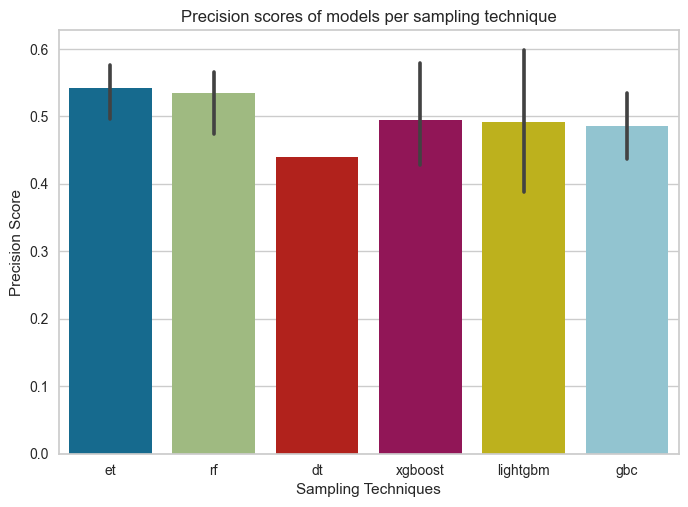

In [1755]:
df = pd.DataFrame(imbalance_type_dict_layer_2)
df = df.T

sns.barplot(df)
plt.xlabel('Sampling Techniques')
plt.ylabel('Precision Score')
plt.title('Precision scores of models per sampling technique')
plt.show()

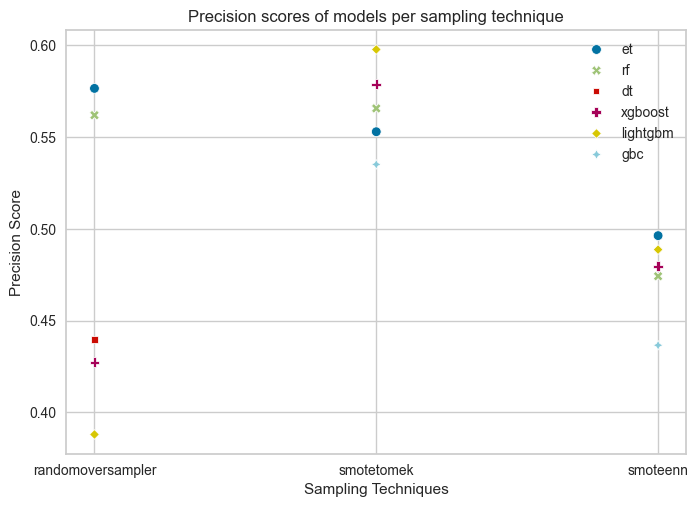

In [1756]:
sns.scatterplot(df)
plt.xlabel('Sampling Techniques')
plt.ylabel('Precision Score')
plt.title('Precision scores of models per sampling technique')
plt.show()

Using Pycaret to see what models work with different sampling techniques the results look to be that multiple tree based models work the best with SmoteTomek as the sampling technique. Below, the ExtraTreeClassifier will be used with a randomoversampling technique and a LightGBM model will be used with SmoteTomek.

In [1757]:
from imblearn.over_sampling import RandomOverSampler

dummy_new_X = pd.get_dummies(data=s.X)

X_train, X_test, y_train, y_test = train_test_split(dummy_new_X, s.y, train_size=.80, random_state=seed)
X_train_resampled_tomek, y_train_resampled_tomek = SMOTETomek(random_state=seed).fit_resample(X_train, y_train)
X_train_resampled_random, y_train_resampled_random = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)


In [1758]:
from sklearn.tree import ExtraTreeClassifier
from lightgbm import LGBMClassifier

second_layer_models = {
    'extra_tree': ExtraTreeClassifier(random_state=seed),
    'lightgbm': LGBMClassifier(random_state=seed)
}

for name, model in second_layer_models.items():
    print(f"{'*'*40} Model: {name} {'*'*40}")
    if name == 'extra_tree':
        extra_tree = model
        extra_tree.fit(X_train_resampled_random, y_train_resampled_random)
        preds = extra_tree.predict(X_test)
        print(classification_report(y_test, preds))
        print(confusion_matrix(y_test, preds))
    else:
        lgbm = model
        lgbm.fit(X_train_resampled_tomek, y_train_resampled_tomek)
        preds = lgbm.predict(X_test)
        print(classification_report(y_test, preds))
        print(confusion_matrix(y_test, preds))

**************************************** Model: extra_tree ****************************************
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7413
           1       0.36      0.36      0.36       587

    accuracy                           0.91      8000
   macro avg       0.66      0.65      0.65      8000
weighted avg       0.91      0.91      0.91      8000

[[7043  370]
 [ 378  209]]
**************************************** Model: lightgbm ****************************************
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7413
           1       0.57      0.54      0.55       587

    accuracy                           0.94      8000
   macro avg       0.77      0.75      0.76      8000
weighted avg       0.93      0.94      0.94      8000

[[7175  238]
 [ 271  316]]


In [1759]:
params = {
    'max_depth': np.arange(1,8),
    'num_leaves': np.arange(2,100,10),
    'min_data_in_leaf': np.arange(100,10000,10),
    'num_iterations': np.arange(2,10),
    'force_row_wise': [True],
    'verbose': [-1]
}

grid = RandomizedSearchCV(estimator=second_layer_models['lightgbm'], param_distributions=params, n_jobs=-1, random_state=seed, cv=5, scoring='precision')

grid.fit(X_train_resampled_tomek, y_train_resampled_tomek)
preds = grid.predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

/Users/smittyboop/Desktop/Term Deposit Marketing Project/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/smittyboop/Desktop/Term Deposit Marketing Project/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/smittyboop/Desktop/Term Deposit Marketing Project/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/smittyboop/Desktop/Term Deposit Marketing Project/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7413
           1       0.33      0.78      0.46       587

    accuracy                           0.87      8000
   macro avg       0.65      0.83      0.69      8000
weighted avg       0.93      0.87      0.89      8000

[[6463  950]
 [ 129  458]]


In [1760]:
def objective(trial):
    lgb_max_depth = trial.suggest_int('lgb_max_depth', 1, 8)
    lgb_num_leaves = trial.suggest_int('lgb_num_leaves', 2,100)
    lgb_min_data_in_leaf = trial.suggest_int('lgb_min_data_in_leaf',100,10000,log=True)
    lgb_num_iter = trial.suggest_int('lgb_num_iter', 2,10)

    regressor_obj = LGBMClassifier(max_depth=lgb_max_depth, num_leaves=lgb_num_leaves, min_data_in_leaf=lgb_min_data_in_leaf, num_iterations=lgb_num_iter, random_state=seed, force_row_wise=True, verbose=-1)
    
    dummy_df = pd.get_dummies(s.X)
    
    X_train, X_test, y_train, y_test = train_test_split(dummy_df, s.y, train_size=.80, random_state=seed)
    X_train_resample, y_train_resample = SMOTETomek(random_state=seed).fit_resample(X_train, y_train)

    regressor_obj.fit(X_train_resample, y_train_resample)
    preds = regressor_obj.predict(X_test)
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2024-09-28 15:18:45,073] A new study created in memory with name: no-name-870cc8aa-9b85-4f33-b06b-0833b084db9c
[W 2024-09-28 15:18:53,566] Trial 0 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 59, 'lgb_min_data_in_leaf': 3857, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:18:53,572] Trial 0 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7413
           1       0.27      0.79      0.41       587

    accuracy                           0.83      8000
   macro avg       0.63      0.81      0.65      8000
weighted avg       0.93      0.83      0.86      8000

[[6179 1234]
 [ 123  464]]


[W 2024-09-28 15:19:04,873] Trial 1 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 13, 'lgb_min_data_in_leaf': 3963, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:19:04,875] Trial 1 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7413
           1       0.27      0.79      0.40       587

    accuracy                           0.83      8000
   macro avg       0.62      0.81      0.65      8000
weighted avg       0.93      0.83      0.86      8000

[[6153 1260]
 [ 124  463]]


[W 2024-09-28 15:19:14,956] Trial 2 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 27, 'lgb_min_data_in_leaf': 629, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:19:14,957] Trial 2 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.78      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6409 1004]
 [ 128  459]]


[W 2024-09-28 15:19:25,240] Trial 3 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 69, 'lgb_min_data_in_leaf': 821, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:19:25,242] Trial 3 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-09-28 15:19:32,756] Trial 4 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 4, 'lgb_min_data_in_leaf': 969, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:19:32,757] Trial 4 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7413
           1       0.30      0.80      0.44       587

    accuracy                           0.85      8000
   macro avg       0.64      0.83      0.68      8000
weighted avg       0.93      0.85      0.88      8000

[[6338 1075]
 [ 116  471]]


[W 2024-09-28 15:19:40,235] Trial 5 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 2, 'lgb_min_data_in_leaf': 7384, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:19:40,237] Trial 5 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-09-28 15:19:47,813] Trial 6 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 6, 'lgb_min_data_in_leaf': 269, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:19:47,814] Trial 6 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7413
           1       0.29      0.82      0.43       587

    accuracy                           0.84      8000
   macro avg       0.64      0.83      0.67      8000
weighted avg       0.93      0.84      0.87      8000

[[6266 1147]
 [ 108  479]]


[W 2024-09-28 15:19:55,290] Trial 7 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 27, 'lgb_min_data_in_leaf': 1865, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:19:55,291] Trial 7 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-09-28 15:20:03,023] Trial 8 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 71, 'lgb_min_data_in_leaf': 4135, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:20:03,024] Trial 8 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.27      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.87      8000

[[6222 1191]
 [ 153  434]]


[W 2024-09-28 15:20:10,347] Trial 9 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 11, 'lgb_min_data_in_leaf': 4197, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:20:10,347] Trial 9 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7413
           1       0.26      0.77      0.39       587

    accuracy                           0.82      8000
   macro avg       0.62      0.80      0.64      8000
weighted avg       0.93      0.82      0.86      8000

[[6143 1270]
 [ 137  450]]


[W 2024-09-28 15:20:19,819] Trial 10 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 29, 'lgb_min_data_in_leaf': 539, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:20:19,820] Trial 10 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-09-28 15:20:29,650] Trial 11 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 96, 'lgb_min_data_in_leaf': 695, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:20:29,651] Trial 11 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.78      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6405 1008]
 [ 127  460]]


[W 2024-09-28 15:20:37,561] Trial 12 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 7, 'lgb_min_data_in_leaf': 906, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:20:37,562] Trial 12 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.80      0.45       587

    accuracy                           0.85      8000
   macro avg       0.65      0.83      0.68      8000
weighted avg       0.93      0.85      0.88      8000

[[6370 1043]
 [ 117  470]]


[W 2024-09-28 15:20:45,493] Trial 13 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 50, 'lgb_min_data_in_leaf': 430, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:20:45,495] Trial 13 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7413
           1       0.34      0.80      0.48       587

    accuracy                           0.87      8000
   macro avg       0.66      0.84      0.70      8000
weighted avg       0.94      0.87      0.89      8000

[[6513  900]
 [ 117  470]]


[W 2024-09-28 15:20:53,117] Trial 14 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 21, 'lgb_min_data_in_leaf': 135, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:20:53,118] Trial 14 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7413
           1       0.29      0.76      0.42       587

    accuracy                           0.85      8000
   macro avg       0.63      0.80      0.67      8000
weighted avg       0.93      0.85      0.88      8000

[[6327 1086]
 [ 143  444]]


[W 2024-09-28 15:21:00,574] Trial 15 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 64, 'lgb_min_data_in_leaf': 6126, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:21:00,576] Trial 15 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-09-28 15:21:07,992] Trial 16 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 94, 'lgb_min_data_in_leaf': 655, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:21:07,992] Trial 16 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7413
           1       0.33      0.81      0.47       587

    accuracy                           0.87      8000
   macro avg       0.66      0.84      0.70      8000
weighted avg       0.94      0.87      0.89      8000

[[6453  960]
 [ 110  477]]


[W 2024-09-28 15:21:15,286] Trial 17 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 22, 'lgb_min_data_in_leaf': 503, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:21:15,287] Trial 17 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7413
           1       0.29      0.77      0.42       587

    accuracy                           0.84      8000
   macro avg       0.63      0.81      0.67      8000
weighted avg       0.93      0.84      0.87      8000

[[6301 1112]
 [ 133  454]]


[W 2024-09-28 15:21:22,890] Trial 18 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 37, 'lgb_min_data_in_leaf': 110, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:21:22,891] Trial 18 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.89      0.94      7413
           1       0.37      0.81      0.51       587

    accuracy                           0.89      8000
   macro avg       0.68      0.85      0.72      8000
weighted avg       0.94      0.89      0.90      8000

[[6618  795]
 [ 114  473]]


[W 2024-09-28 15:21:30,434] Trial 19 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 23, 'lgb_min_data_in_leaf': 1307, 'lgb_num_iter': 6} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:21:30,435] Trial 19 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-09-28 15:21:37,790] Trial 20 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 48, 'lgb_min_data_in_leaf': 353, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:21:37,791] Trial 20 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7413
           1       0.32      0.78      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.69      8000
weighted avg       0.93      0.86      0.89      8000

[[6427  986]
 [ 130  457]]


[W 2024-09-28 15:21:45,288] Trial 21 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 30, 'lgb_min_data_in_leaf': 118, 'lgb_num_iter': 8} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:21:45,289] Trial 21 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.78      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6412 1001]
 [ 128  459]]


[W 2024-09-28 15:21:52,812] Trial 22 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 13, 'lgb_min_data_in_leaf': 101, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:21:52,813] Trial 22 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-09-28 15:22:00,543] Trial 23 failed with parameters: {'lgb_max_depth': 4, 'lgb_num_leaves': 26, 'lgb_min_data_in_leaf': 1677, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:22:00,544] Trial 23 failed with value None.


              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7413
           1       0.30      0.71      0.42       587

    accuracy                           0.86      8000
   macro avg       0.64      0.79      0.67      8000
weighted avg       0.93      0.86      0.88      8000

[[6439  974]
 [ 168  419]]


[W 2024-09-28 15:22:07,984] Trial 24 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 59, 'lgb_min_data_in_leaf': 322, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:22:07,985] Trial 24 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7413
           1       0.31      0.78      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6404 1009]
 [ 128  459]]


[W 2024-09-28 15:22:15,656] Trial 25 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 75, 'lgb_min_data_in_leaf': 564, 'lgb_num_iter': 3} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:22:15,657] Trial 25 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7413
           1       0.35      0.79      0.48       587

    accuracy                           0.88      8000
   macro avg       0.66      0.84      0.71      8000
weighted avg       0.94      0.88      0.90      8000

[[6539  874]
 [ 121  466]]


[W 2024-09-28 15:22:24,412] Trial 26 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 61, 'lgb_min_data_in_leaf': 2036, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:22:24,413] Trial 26 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7413
           1       0.29      0.79      0.43       587

    accuracy                           0.84      8000
   macro avg       0.64      0.82      0.67      8000
weighted avg       0.93      0.84      0.87      8000

[[6290 1123]
 [ 122  465]]


[W 2024-09-28 15:22:32,113] Trial 27 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 6, 'lgb_min_data_in_leaf': 2789, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:22:32,114] Trial 27 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.79      0.88      7413
           1       0.24      0.82      0.37       587

    accuracy                           0.79      8000
   macro avg       0.61      0.80      0.62      8000
weighted avg       0.93      0.79      0.84      8000

[[5868 1545]
 [ 107  480]]


[W 2024-09-28 15:22:39,666] Trial 28 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 7, 'lgb_min_data_in_leaf': 1279, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:22:39,667] Trial 28 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7413
           1       0.31      0.76      0.44       587

    accuracy                           0.86      8000
   macro avg       0.64      0.81      0.68      8000
weighted avg       0.93      0.86      0.88      8000

[[6426  987]
 [ 142  445]]


[W 2024-09-28 15:22:47,210] Trial 29 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 38, 'lgb_min_data_in_leaf': 3545, 'lgb_num_iter': 4} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:22:47,212] Trial 29 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.24      0.81      0.38       587

    accuracy                           0.80      8000
   macro avg       0.61      0.81      0.63      8000
weighted avg       0.93      0.80      0.85      8000

[[5944 1469]
 [ 111  476]]


[W 2024-09-28 15:22:54,869] Trial 30 failed with parameters: {'lgb_max_depth': 1, 'lgb_num_leaves': 19, 'lgb_min_data_in_leaf': 792, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:22:54,871] Trial 30 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7413
           1       0.26      0.74      0.39       587

    accuracy                           0.83      8000
   macro avg       0.62      0.79      0.65      8000
weighted avg       0.92      0.83      0.86      8000

[[6203 1210]
 [ 153  434]]


[W 2024-09-28 15:23:02,774] Trial 31 failed with parameters: {'lgb_max_depth': 2, 'lgb_num_leaves': 4, 'lgb_min_data_in_leaf': 210, 'lgb_num_iter': 7} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:23:02,776] Trial 31 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7413
           1       0.29      0.78      0.42       587

    accuracy                           0.84      8000
   macro avg       0.63      0.81      0.66      8000
weighted avg       0.93      0.84      0.87      8000

[[6268 1145]
 [ 130  457]]


[W 2024-09-28 15:23:10,218] Trial 32 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 52, 'lgb_min_data_in_leaf': 2729, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:23:10,219] Trial 32 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.25      0.82      0.38       587

    accuracy                           0.80      8000
   macro avg       0.62      0.81      0.63      8000
weighted avg       0.93      0.80      0.85      8000

[[5952 1461]
 [ 105  482]]


[W 2024-09-28 15:23:17,671] Trial 33 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 52, 'lgb_min_data_in_leaf': 1439, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:23:17,672] Trial 33 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7413
           1       0.32      0.77      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.69      8000
weighted avg       0.93      0.86      0.89      8000

[[6449  964]
 [ 133  454]]


[W 2024-09-28 15:23:25,567] Trial 34 failed with parameters: {'lgb_max_depth': 8, 'lgb_num_leaves': 90, 'lgb_min_data_in_leaf': 840, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:23:25,568] Trial 34 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7413
           1       0.34      0.81      0.48       587

    accuracy                           0.87      8000
   macro avg       0.66      0.84      0.70      8000
weighted avg       0.94      0.87      0.89      8000

[[6497  916]
 [ 114  473]]


[W 2024-09-28 15:23:33,663] Trial 35 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 90, 'lgb_min_data_in_leaf': 104, 'lgb_num_iter': 10} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:23:33,664] Trial 35 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.89      0.94      7413
           1       0.37      0.80      0.51       587

    accuracy                           0.89      8000
   macro avg       0.68      0.85      0.72      8000
weighted avg       0.94      0.89      0.90      8000

[[6624  789]
 [ 119  468]]


[W 2024-09-28 15:23:41,530] Trial 36 failed with parameters: {'lgb_max_depth': 5, 'lgb_num_leaves': 55, 'lgb_min_data_in_leaf': 3729, 'lgb_num_iter': 5} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:23:41,532] Trial 36 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7413
           1       0.24      0.81      0.37       587

    accuracy                           0.80      8000
   macro avg       0.61      0.81      0.63      8000
weighted avg       0.93      0.80      0.84      8000

[[5922 1491]
 [ 110  477]]


[W 2024-09-28 15:23:49,975] Trial 37 failed with parameters: {'lgb_max_depth': 6, 'lgb_num_leaves': 20, 'lgb_min_data_in_leaf': 187, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:23:49,976] Trial 37 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7413
           1       0.36      0.82      0.50       587

    accuracy                           0.88      8000
   macro avg       0.67      0.85      0.71      8000
weighted avg       0.94      0.88      0.90      8000

[[6539  874]
 [ 103  484]]


[W 2024-09-28 15:23:59,231] Trial 38 failed with parameters: {'lgb_max_depth': 7, 'lgb_num_leaves': 38, 'lgb_min_data_in_leaf': 346, 'lgb_num_iter': 2} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:23:59,232] Trial 38 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7413
           1       0.34      0.78      0.48       587

    accuracy                           0.88      8000
   macro avg       0.66      0.83      0.70      8000
weighted avg       0.93      0.88      0.90      8000

[[6543  870]
 [ 129  458]]


[W 2024-09-28 15:24:07,394] Trial 39 failed with parameters: {'lgb_max_depth': 3, 'lgb_num_leaves': 23, 'lgb_min_data_in_leaf': 695, 'lgb_num_iter': 9} because of the following error: The value None could not be cast to float..
[W 2024-09-28 15:24:07,396] Trial 39 failed with value None.


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7413
           1       0.32      0.78      0.45       587

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.89      8000

[[6419  994]
 [ 129  458]]


              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7413
           1       0.36      0.82      0.50       587

    accuracy                           0.88      8000
   macro avg       0.67      0.85      0.71      8000
weighted avg       0.94      0.88      0.90      8000



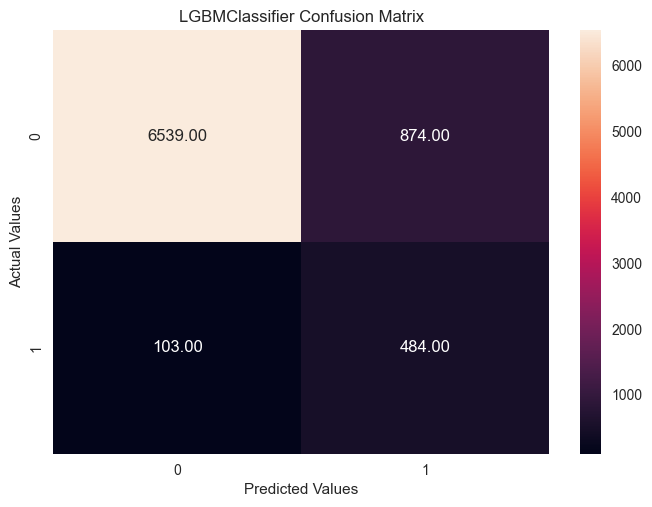

In [1762]:

lgb_tuned = LGBMClassifier(max_depth=6, num_leaves=20, min_data_in_leaf=187, num_iterations=9, random_state=seed, force_row_wise=True, verbose=-1)
lgb_tuned.fit(X_train_resampled_tomek, y_train_resampled_tomek)
preds = lgb_tuned.predict(X_test)
print(classification_report(y_test, preds))
sns.heatmap(data=confusion_matrix(y_test, preds), annot=True, fmt='.2f')
plt.title('LGBMClassifier Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [1763]:
duration_of_calls_in_hours = round(X['duration_in_minutes'].sum()/60, 2)
print(f"The total amount of call time during the entirety of the campaign was {duration_of_calls_in_hours} hours.")

The total amount of call time during the entirety of the campaign was 2831.38 hours.


In [1764]:
from sklearn.feature_selection import RFE, RFECV

selector = RFE(estimator=lgb_tuned, step=1)
selector.fit(X_train_resampled_tomek, y_train_resampled_tomek)
ranking = sorted(selector.ranking_)

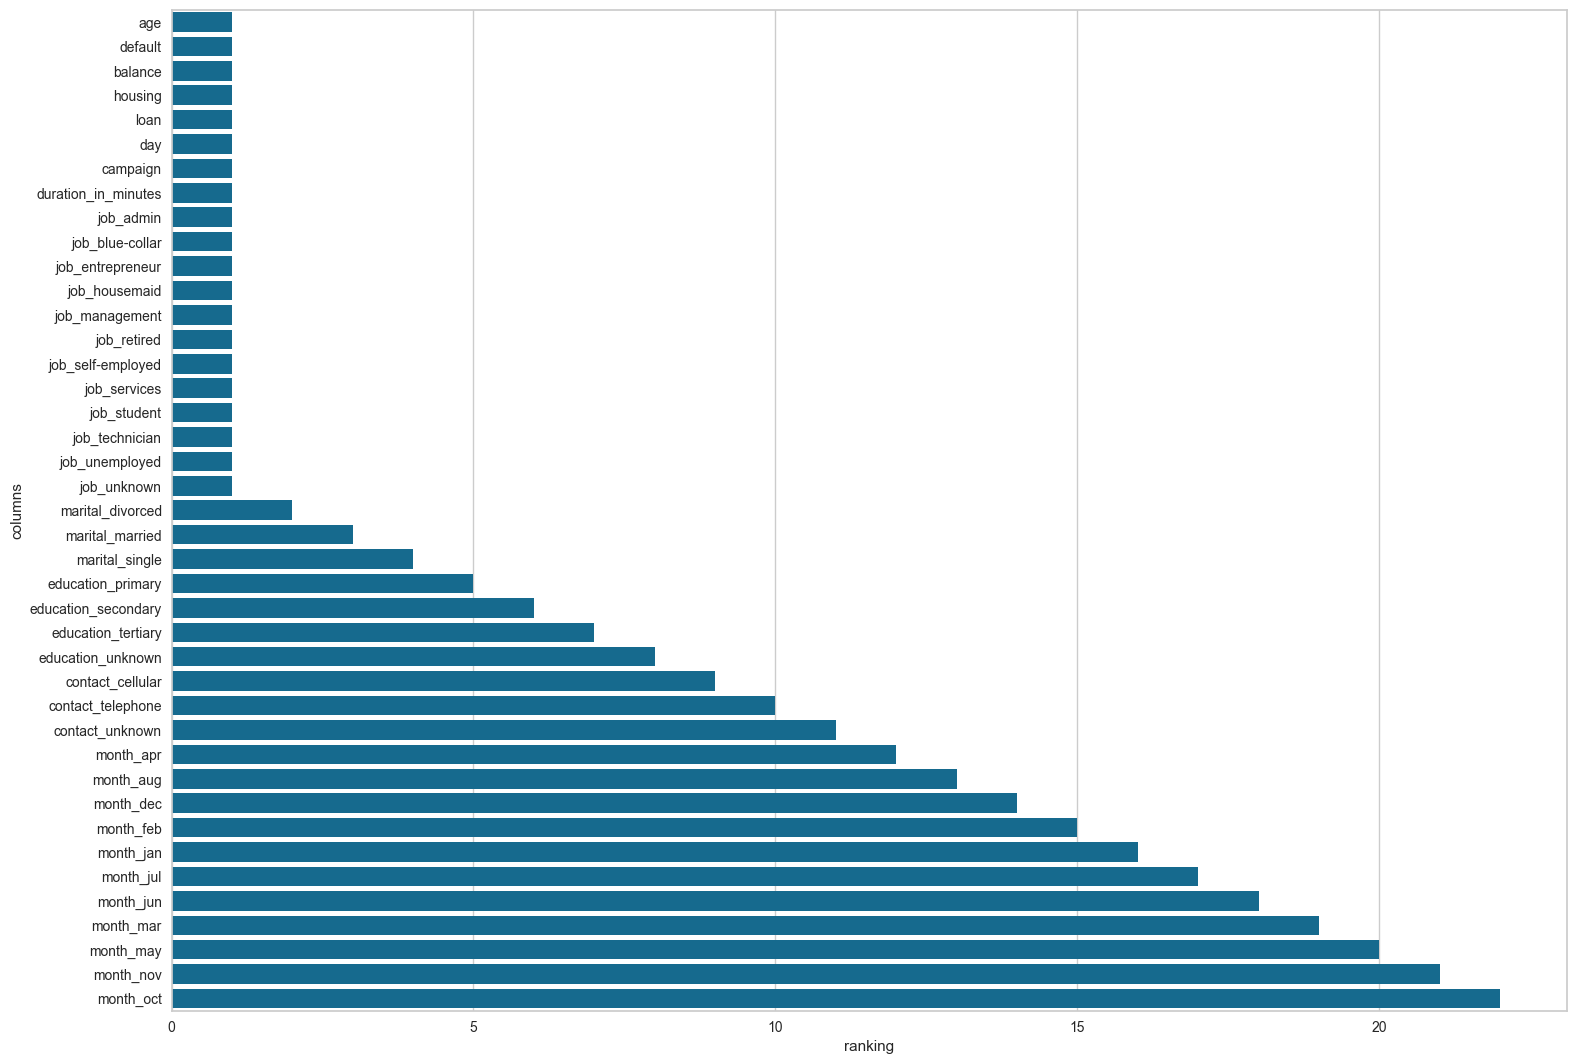

In [1765]:
ranking_df = pd.DataFrame({'columns': X_train_resampled_tomek.columns, 'ranking': ranking})

plt.figure(figsize=(18, 13))
sns.barplot(data=ranking_df, x='ranking', y='columns')
plt.show()

In [1766]:
top_feature_ranking = int(len([i for i in ranking if i == 1]))
print(top_feature_ranking)

20


In [1767]:
cv_selector = RFECV(estimator=lgb_tuned, step=1, min_features_to_select=top_feature_ranking, cv=5)
cv_selector.fit(X_train_resampled_tomek, y_train_resampled_tomek)
cv_rankings = cv_selector.ranking_
cv_rankings = sorted(cv_rankings)

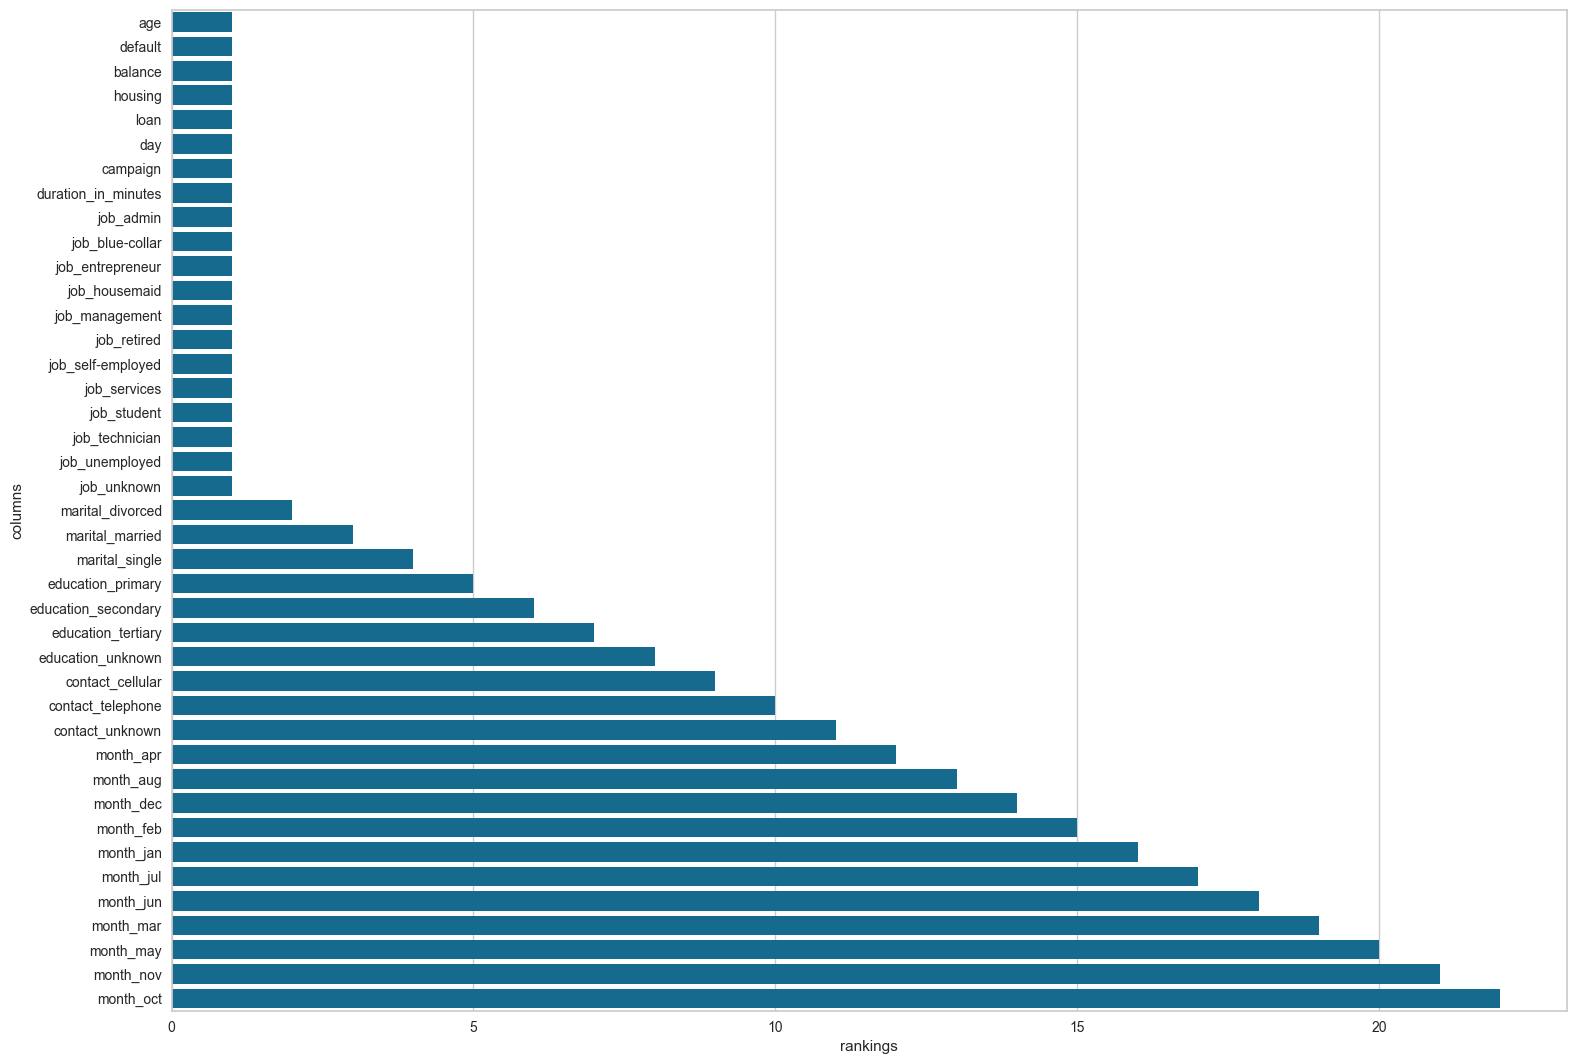

In [1768]:
cv_rfe_df = pd.DataFrame({'columns': X_train_resampled_tomek.columns, 'rankings': cv_rankings})

plt.figure(figsize=(18, 13))
sns.barplot(data=cv_rfe_df, x='rankings', y='columns')
plt.show()

In [1769]:
rankings_df = pd.DataFrame({'columns': X_train_resampled_tomek.columns, 'rfe_rankings': ranking, 'cv_rfe_rankings': cv_rankings})

rankings_df.head()

,columns,rfe_rankings,cv_rfe_rankings
0,age,1,1
1,default,1,1
2,balance,1,1
3,housing,1,1
4,loan,1,1


In [1770]:
cv_rankings_1 = rankings_df[rankings_df['cv_rfe_rankings']==1]
columns_to_train = cv_rankings_1['columns'].tolist()

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7413
           1       0.28      0.78      0.42       587

    accuracy                           0.84      8000
   macro avg       0.63      0.81      0.66      8000
weighted avg       0.93      0.84      0.87      8000



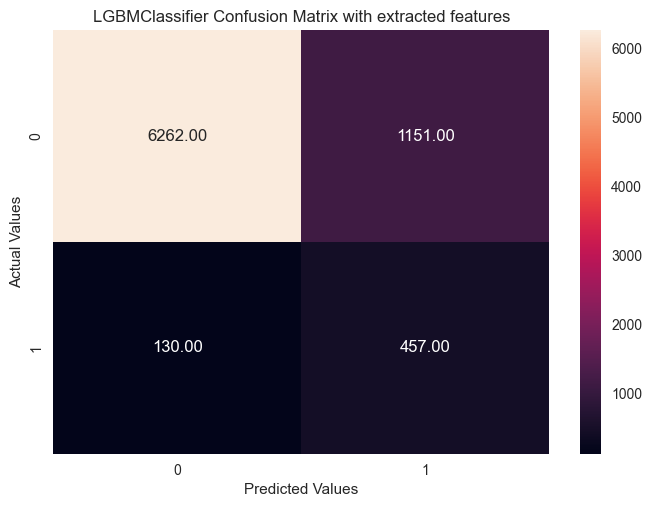

In [1771]:
X_train, X_test, y_train, y_test = train_test_split(dummy_new_X[columns_to_train], s.y, train_size=.80, random_state=seed)
X_train_resample, y_train_resample = SMOTETomek(random_state=seed).fit_resample(X_train, y_train)

lgb_tuned.fit(X_train_resample, y_train_resample)
preds = lgb_tuned.predict(X_test)
print(classification_report(y_test, preds))

sns.heatmap(data=confusion_matrix(y_test, preds), fmt='.2f', annot=True)
plt.title('LGBMClassifier Confusion Matrix with extracted features')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [1772]:
columns_to_train

['age',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'campaign',
 'duration_in_minutes',
 'job_admin',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown']

## Conclusion

* With certain features extracted the LGBMClassifer classifies more false positives which was the goal from the onset of this section of modeling.
* With those false positives we can calculate the call time saved to be close to 60 hours while only losing 130 potential subscribers to the term deposit product. 
* Using the select columns above the model gains over 250 false positive classifications that can be negated from making calls to while only losing an additional 25 potential customers.